In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from scipy.sparse import lil_matrix

import re

In [2]:
# read data file: contains all text data concatenated into a single file
# with open('../data/AllCombined.txt', 'r', encoding='utf-8') as f:
#     contents = f.read()

# read data
df = pd.read_csv('../data/twitter/train.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
contents = list(df['text'])[:50000]

In [3]:
# split text into sentences by fullstop and lowercase everything up to 20000 sentences
sentences_lst = [tweet.lower() for tweet in contents]

# remove punctuation
sentences_lst_removed_punc = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences_lst]

# tokenize the split sentences into words
tokenized_sentences = [sentence.split() for sentence in sentences_lst_removed_punc]

In [4]:
vocab = {
    word: idx for idx, word in enumerate(set(word for sentence in tokenized_sentences for word in sentence))
}

In [5]:
vocab_size = len(vocab)
co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

In [6]:
window_size = 2  # Only consider words within 2 positions on either side
k = 5 # for log(k) later

for sentence in tokenized_sentences:
    sentence_length = len(sentence)
    for idx, word in enumerate(sentence):
        word_idx = vocab[word]
        
        # Define the context window
        start = max(0, idx - window_size)
        end = min(sentence_length, idx + window_size + 1)
        
        # Update co-occurrence counts for words in the window
        for context_idx in range(start, end):
            if idx != context_idx:  # Skip the word itself
                context_word_idx = vocab[sentence[context_idx]]
                co_matrix[word_idx, context_word_idx] += 1

In [7]:
co_occurrence_sum = np.sum(co_matrix)
word_occurrences = np.sum(co_matrix, axis=1)
pmi_matrix = np.zeros_like(co_matrix)

In [8]:
# Find indices where co_matrix > 0
rows, cols = np.nonzero(co_matrix)

for i, j in zip(rows, cols):
    pmi = np.log((co_matrix[i, j] * co_occurrence_sum) / (word_occurrences[i] * word_occurrences[j]))
    pmi_subtract_log = pmi - np.log(k)
    pmi_matrix[i, j] = max(pmi_subtract_log, 0)  # SPPMI

In [9]:
dim = 300  # Number of dimensions

svd = TruncatedSVD(n_components=dim)
U_k = svd.fit_transform(pmi_matrix)
Sigma_k = np.diag(svd.singular_values_)

In [15]:
Sigma_k_sqrt = np.sqrt(Sigma_k)
pmi_embeddings = U_k @ Sigma_k_sqrt

## Analysis

### Nearest Neighbours for selected words

In [11]:
word_to_index = vocab
index_to_word = {idx: word for word, idx in vocab.items()}

def get_similar_words(word, embeddings, top_k=10):
    idx = word_to_index[word]
    vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(vec, embeddings)[0]
    # Get top_n indices (excluding the word itself)
    top_indices = np.argsort(-sims)[1:top_k + 1]
    return [(index_to_word[i], sims[i]) for i in top_indices]

In [12]:
selected_words = [
    'cow',
    'fight',
    'chemistry',
    'month',
    'energy'
]

for word in selected_words:
    print(f"Similar words to '{word}':")
    print(get_similar_words(word, pmi_embeddings))
    print("*" * 30)

Similar words to 'cow':
[('laughing', 0.5382179), ('girlnamedsam', 0.5315834), ('sup3rmaann', 0.5163022), ('ulnar', 0.5039599), ('eating', 0.5015526), ('crying', 0.49606833), ('sausage', 0.49001664), ('youbeing', 0.48998073), ('pulledhorses', 0.48580387), ('cream', 0.48254037)]
******************************
Similar words to 'fight':
[('career', 0.5431001), ('war', 0.5118879), ('match', 0.50880355), ('deep', 0.49755517), ('hubby', 0.4954868), ('books', 0.48484486), ('camera', 0.4842454), ('seeing', 0.48146087), ('fresh', 0.48033714), ('silva', 0.47934443)]
******************************
Similar words to 'chemistry':
[('revision', 0.76672804), ('science', 0.7659105), ('bio', 0.7460909), ('math', 0.7433201), ('biology', 0.73541117), ('history', 0.73402834), ('coursework', 0.7253058), ('maths', 0.6961849), ('paper', 0.69172096), ('studying', 0.67680275)]
******************************
Similar words to 'month':
[('year', 0.74342704), ('9', 0.71411836), ('months', 0.71023786), ('spend', 0.7

### Visualization of embedding space

In [13]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(pmi_embeddings)

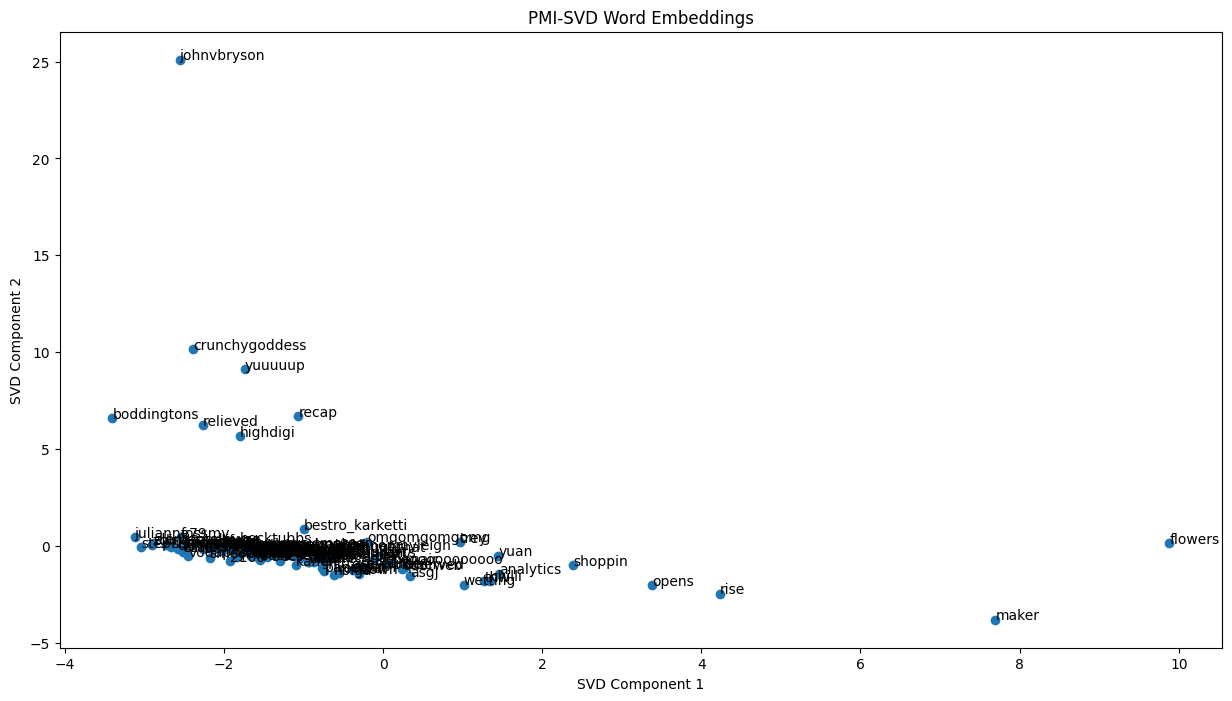

In [14]:
words = list(vocab.keys())[:100]

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:100, 0], reduced_embeddings[:100, 1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("PMI-SVD Word Embeddings")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()